<a href="https://colab.research.google.com/github/madhusudhanrao-ppm/dbdevrel/blob/main/source-codes/colab-code/unesco-sites-selectai-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oracle SelectAI with UNESCO World Heritage Sites - Google Colab Notebook

This notebook demonstrates how to connect to Oracle Autonomous Database using wallet-based authentication and execute SelectAI queries with Cohere integration in Google Colab, specifically focused on UNESCO World Heritage Sites.

**Prerequisites**:
- Oracle Autonomous Database instance
- Wallet files downloaded from Oracle Cloud Console in to Google Drive
- Generate Cohere API key
- Google Drive account for storing wallet files
- UNESCO_SITES table with World Heritage data ([Sample Data Table](https://github.com/madhusudhanrao-ppm/code-assets/blob/main/AI-for-Travel/UNESCO_SITES_sample_data.csv))
- Create Table UNESCO_SITES
- For more instructions please refer README.md file

Date Updated: 21st Jan 2026

## Section 1: Install Required Libraries and Dependencies

Install the necessary packages including oracledb for Oracle database connectivity in Google Colab.

In [1]:
!pip install oracledb pandas folium geopandas -q
import oracledb
import pandas as pd
import os
import json
from pathlib import Path
import folium
from folium import plugins

print("✓ oracledb and visualization libraries installed successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.0 MB/s eta 0:00:00
✓ oracledb and visualization libraries installed successfully


## Section 2: Download and Configure Oracle Wallet

Mount Google Drive and download your Oracle wallet files. Upload your wallet.zip file to Google Drive first.

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print("✓ Google Drive mounted successfully")

Mounted at /content/drive
✓ Google Drive mounted successfully


## Section 3: Establish Connection to Oracle Autonomous Database

Create and test the database connection using wallet-based authentication.

In [7]:
# Connection parameters
username = "DEMOUSER"  # Update with your username
adminusername = "ADMIN"  # Update with your admin username
password = "YourPassword"  # Update with your password
tns_name = "indeducation_high"  # Update with your TNS alias from tnsnames.ora
wall_config_dir = "/content/drive/MyDrive/Wallet_YourFolder"  # Update with your wallet path
wall_pwd = "YourWalletPassword"  # Update with your wallet password

try:
    # Connect to Oracle Database
    conn = oracledb.connect(user=adminusername,
                              password=password,
                              dsn=tns_name,
                              config_dir=wall_config_dir,
                              wallet_location=wall_config_dir,
                              wallet_password=wall_pwd)

    print("✓ Successfully connected to Oracle Database as ADMIN user")

    # Test connection with a simple query
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM DEMOUSER.UNESCO_SITES")
    count = cursor.fetchone()[0]
    print(f"✓ UNESCO_SITES table contains {count} records")

except Exception as e:
    print(f"✗ Connection failed: {e}")
    conn = None

✓ Successfully connected to Oracle Database as ADMIN user
✓ UNESCO_SITES table contains 1113 records


## Section 4: Grant Privileges and Setup SelectAI (Admin Tasks)

Grant necessary privileges for SelectAI. These commands should be executed as ADMIN user.

In [ ]:
# SQL commands to execute as ADMIN
# Note: Run these manually as ADMIN user in Oracle SQL Developer or SQL*Plus

admin_sql_commands = """
-- Grant required privileges to DEMOUSER (as ADMIN)
GRANT execute ON DBMS_CLOUD TO DEMOUSER;
GRANT execute ON DBMS_CLOUD_AI TO DEMOUSER;
COMMIT;

-- Configure Network ACL for Cohere API
BEGIN
    DBMS_NETWORK_ACL_ADMIN.APPEND_HOST_ACE(
         host => 'api.cohere.ai',
         ace  => xs$ace_type(privilege_list => xs$name_list('http'),
                             principal_name => 'DEMOUSER',
                             principal_type => xs_acl.ptype_db)
   );
END;
/
COMMIT;
"""

print("Admin Setup Commands (Execute these as ADMIN user):")
print("=" * 60)
print(admin_sql_commands)
print("=" * 60)

## Section 5: Create Sample Table and Setup AI Credentials

Create a copy of the UNESCO_SITES table and configure Cohere credentials for SelectAI.

In [9]:
# Configuration variables
cohere_api_key = 'YourCohereKey'  # Get from https://cohere.ai/
username = 'DEMOUSER'

# Close admin connection and reconnect as DEMOUSER
if conn:
    conn.close()

try:
    # Connect as DEMOUSER
    conn = oracledb.connect(user=username,
                              password=password,
                              dsn=tns_name,
                              config_dir=wall_config_dir,
                              wallet_location=wall_config_dir,
                              wallet_password=wall_pwd)

    print("✓ Successfully connected to Oracle Database as DEMOUSER")
    cursor = conn.cursor()

except Exception as e:
    print(f"✗ Connection failed: {e}")
    conn = None

if conn:
    # Step 1: Create a copy of the UNESCO_SITES table
    try:
        cursor.execute(f"""
        CREATE TABLE {username}.UNESCO_SITES_COPY AS
        SELECT * FROM UNESCO_SITES
        """)
        conn.commit()
        print(f"✓ Sample table UNESCO_SITES_COPY created for {username}")
    except oracledb.DatabaseError as e:
        if 'already exists' in str(e):
            print(f"ℹ Table UNESCO_SITES_COPY already exists, skipping creation")
        else:
            print(f"⚠ Error creating table: {e}")

    # Step 2: Create AI Credential for Cohere
    try:
        cursor.execute(f"""
        BEGIN
            DBMS_CLOUD.create_credential(
                'COHERE_CRED',
                'COHERE',
                '{cohere_api_key}'
            );
        END;
        """)
        conn.commit()
        print("✓ Cohere credential 'COHERE_CRED' created successfully")
    except oracledb.DatabaseError as e:
        if 'already exists' in str(e):
            print("ℹ Credential COHERE_CRED already exists, skipping creation")
        else:
            print(f"⚠ Error creating credential: {e}")

✓ Successfully connected to Oracle Database as DEMOUSER
✓ Sample table UNESCO_SITES_COPY created for DEMOUSER
ℹ Credential COHERE_CRED already exists, skipping creation


## Section 6: Create AI Profile

Create an AI profile that defines which tables SelectAI should have access to.

In [11]:
# Create AI Profile for Cohere
profile_json = json.dumps({
    "provider": "COHERE",
    "credential_name": "COHERE_CRED",
    "object_list": [{"owner": username, "name": "UNESCO_SITES_COPY"}]
})

if conn:
    try:
        cursor.execute(f"""
        BEGIN
          DBMS_CLOUD_AI.create_profile(
              'COHERE_UNESCO',
              '{profile_json}'
            );
        END;
        """)
        conn.commit()
        print("✓ AI Profile 'COHERE_UNESCO' created successfully")
    except oracledb.DatabaseError as e:
        if 'already exists' in str(e):
            print("ℹ Profile COHERE_UNESCO already exists, skipping creation")
        else:
            print(f"⚠ Error creating profile: {e}")

    # Set the profile as active
    try:
        cursor.execute("BEGIN DBMS_CLOUD_AI.set_profile('COHERE_UNESCO'); END;")
        conn.commit()
        print("✓ Profile COHERE_UNESCO set as active")
    except oracledb.DatabaseError as e:
        print(f"⚠ Error setting profile: {e}")

ℹ Profile COHERE_UNESCO already exists, skipping creation
✓ Profile COHERE_UNESCO set as active


## Section 7: Explore UNESCO SITES Data Structure

Let's examine the structure and sample data of the UNESCO_SITES table.

In [12]:
if conn:
    # Get table structure
    cursor.execute("""
    SELECT column_name, data_type, data_length
    FROM user_tab_columns
    WHERE table_name = 'UNESCO_SITES_COPY'
    ORDER BY column_id
    """)

    print("UNESCO_SITES_COPY Table Structure:")
    print("=" * 50)
    for row in cursor.fetchall():
        print(f"{row[0]:20} | {row[1]:15} | Length: {row[2]}")

    # Get sample data
    cursor.execute("""
    SELECT ID, NAME_EN, STATES_NAME_EN, REGION_EN, CATEGORY, LATITUDE, LONGITUDE
    FROM UNESCO_SITES_COPY
    WHERE ROWNUM <= 5
    """)

    print("\nSample Data:")
    print("=" * 80)
    for row in cursor.fetchall():
        print(f"ID: {row[0]}, Name: {row[1][:30]:30}, Country: {row[2]:20}, Region: {row[3]:20}")
        print(f"    Category: {row[4]}, Lat: {row[5]}, Lon: {row[6]}")
        print("-" * 80)

UNESCO_SITES_COPY Table Structure:
ID                   | NUMBER          | Length: 22
LATITUDE             | NUMBER          | Length: 22
LONGITUDE            | NUMBER          | Length: 22
CATEGORY             | VARCHAR2        | Length: 50
STATES_NAME_EN       | VARCHAR2        | Length: 255
REGION_EN            | VARCHAR2        | Length: 255
NAME_EN              | VARCHAR2        | Length: 255

Sample Data:
ID: 1, Name: Pennsula Valds                , Country: Argentina           , Region: Latin America and the Caribbean
    Category: Natural, Lat: -42.5, Lon: -64
--------------------------------------------------------------------------------
ID: 2, Name: Ischigualasto / Talampaya Natu, Country: Argentina           , Region: Latin America and the Caribbean
    Category: Natural, Lat: -30, Lon: -68
--------------------------------------------------------------------------------
ID: 3, Name: Jesuit Block and Estancias of , Country: Argentina           , Region: Latin America and th

## Section 8: Geographic Query Examples with SelectAI

Now let's demonstrate SelectAI with various geographic queries on UNESCO World Heritage Sites.

In [14]:
if conn:
    print("\n" + "="*80)
    print("GEOGRAPHIC QUERY EXAMPLES WITH SELECTAI")
    print("="*80)

    # Example 1: Region-based query
    prompt1 = 'Show me all UNESCO sites in Australia'

    try:
        cursor.execute(f"""
        SELECT DBMS_CLOUD_AI.GENERATE(
            prompt       => '{prompt1}',
            profile_name => 'COHERE_UNESCO',
            action       => 'showsql'
        ) as generated_query
        FROM dual
        """)

        result = cursor.fetchone()
        generated_sql = result[0]

        print(f"\nQuery 1: {prompt1}")
        print("=" * 70)
        print("Generated SQL:")
        print(generated_sql)
        print()

        # Execute the query and show results
        cursor.execute(str(generated_sql))
        rows = cursor.fetchall()
        col_names = [description[0] for description in cursor.description]

        df = pd.DataFrame(rows, columns=col_names)
        print(f"Results: {len(df)} sites found")
        print(df.head())

    except Exception as e:
        print(f"✗ Error in Query 1: {e}")


GEOGRAPHIC QUERY EXAMPLES WITH SELECTAI

Query 1: Show me all UNESCO sites in Australia
Generated SQL:
SELECT "ID", "NAME_EN", "REGION_EN", "STATES_NAME_EN", "CATEGORY", "LONGITUDE", "LATITUDE"
FROM "DEMOUSER"."UNESCO_SITES_COPY" us
WHERE UPPER("STATES_NAME_EN") = UPPER('Australia')

Results: 20 sites found
   ID                                            NAME_EN  \
0   7                         Heard and McDonald Islands   
1   8                       Shark Bay, Western Australia   
2   9                                   Macquarie Island   
3  10                                      Fraser Island   
4  11  Australian Fossil Mammal Sites (Riversleigh / ...   

              REGION_EN STATES_NAME_EN CATEGORY   LONGITUDE   LATITUDE  
0  Asia and the Pacific      Australia  Natural   73.500000 -53.100000  
1  Asia and the Pacific      Australia  Natural  113.436111 -25.486111  
2  Asia and the Pacific      Australia  Natural  158.895556 -54.594722  
3  Asia and the Pacific      Australi

In [15]:
if conn:
    # Example 2: Country-specific query
    prompt2 = 'Find all cultural heritage sites in Belgium'

    try:
        cursor.execute(f"""
        SELECT DBMS_CLOUD_AI.GENERATE(
            prompt       => '{prompt2}',
            profile_name => 'COHERE_UNESCO',
            action       => 'showsql'
        ) as generated_query
        FROM dual
        """)

        result = cursor.fetchone()
        generated_sql_2 = result[0]

        print(f"\nQuery 2: {prompt2}")
        print("=" * 70)
        print("Generated SQL:")
        print(generated_sql_2)
        print()

        # Execute the query and show results
        cursor.execute(str(generated_sql_2))
        rows = cursor.fetchall()
        col_names = [description[0] for description in cursor.description]

        df = pd.DataFrame(rows, columns=col_names)
        print(f"Results: {len(df)} sites found")
        print(df.head())

    except Exception as e:
        print(f"✗ Error in Query 2: {e}")


Query 2: Find all cultural heritage sites in Belgium
Generated SQL:
SELECT "US"."ID", "US"."NAME_EN", "US"."REGION_EN", "US"."STATES_NAME_EN", "US"."CATEGORY"
FROM "DEMOUSER"."UNESCO_SITES_COPY" "US"
WHERE UPPER("US"."STATES_NAME_EN") = 'BELGIUM'
AND UPPER("US"."CATEGORY") = 'CULTURAL'

Results: 10 sites found
   ID                                            NAME_EN  \
0  50                                Flemish BÃ©guinages   
1  51  The Four Lifts on the Canal du Centre and thei...   
2  52                           La Grand-Place, Brussels   
3  53                          Historic Centre of Brugge   
4  54  Major Town Houses of the Architect Victor Hort...   

                  REGION_EN STATES_NAME_EN  CATEGORY  
0  Europe and North America        Belgium  Cultural  
1  Europe and North America        Belgium  Cultural  
2  Europe and North America        Belgium  Cultural  
3  Europe and North America        Belgium  Cultural  
4  Europe and North America        Belgium  Cultura

In [16]:
if conn:
    # Example 3: Coordinate-based query
    prompt3 = 'List natural sites with latitude between 40 and 50'

    try:
        cursor.execute(f"""
        SELECT DBMS_CLOUD_AI.GENERATE(
            prompt       => '{prompt3}',
            profile_name => 'COHERE_UNESCO',
            action       => 'showsql'
        ) as generated_query
        FROM dual
        """)

        result = cursor.fetchone()
        generated_sql_3 = result[0]

        print(f"\nQuery 3: {prompt3}")
        print("=" * 70)
        print("Generated SQL:")
        print(generated_sql_3)
        print()

        # Execute the query and show results
        cursor.execute(str(generated_sql_3))
        rows = cursor.fetchall()
        col_names = [description[0] for description in cursor.description]

        df = pd.DataFrame(rows, columns=col_names)
        print(f"Results: {len(df)} sites found")
        print(df.head())

    except Exception as e:
        print(f"✗ Error in Query 3: {e}")


Query 3: List natural sites with latitude between 40 and 50
Generated SQL:
SELECT "ID", "NAME_EN", "REGION_EN", "STATES_NAME_EN", "CATEGORY", "LONGITUDE", "LATITUDE"
FROM "DEMOUSER"."UNESCO_SITES_COPY" us
WHERE UPPER("CATEGORY") = 'NATURAL'
AND "LATITUDE" BETWEEN 40 AND 50

Results: 28 sites found
    ID                                            NAME_EN  \
0   95                            Srebarna Nature Reserve   
1   96                                Pirin National Park   
2  103                             Miguasha National Park   
3  106                              Joggins Fossil Cliffs   
4  300  Gulf of Porto: Calanche of Piana, Gulf of Giro...   

                  REGION_EN STATES_NAME_EN CATEGORY  LONGITUDE   LATITUDE  
0  Europe and North America       Bulgaria  Natural  27.078060  44.114440  
1  Europe and North America       Bulgaria  Natural  23.430472  41.742722  
2  Europe and North America         Canada  Natural -66.353056  48.105000  
3  Europe and North America  

In [17]:
if conn:
    # Example 4: Complex multi-criteria query
    prompt4 = 'Which countries have the most UNESCO sites and show me the top 5'

    try:
        cursor.execute(f"""
        SELECT DBMS_CLOUD_AI.GENERATE(
            prompt       => '{prompt4}',
            profile_name => 'COHERE_UNESCO',
            action       => 'showsql'
        ) as generated_query
        FROM dual
        """)

        result = cursor.fetchone()
        generated_sql_4 = result[0]

        print(f"\nQuery 4: {prompt4}")
        print("=" * 70)
        print("Generated SQL:")
        print(generated_sql_4)
        print()

        # Execute the query and show results
        cursor.execute(str(generated_sql_4))
        rows = cursor.fetchall()
        col_names = [description[0] for description in cursor.description]

        df = pd.DataFrame(rows, columns=col_names)
        print(f"Results: {len(df)} countries found")
        print(df.head())

    except Exception as e:
        print(f"✗ Error in Query 4: {e}")


Query 4: Which countries have the most UNESCO sites and show me the top 5
Generated SQL:
SELECT "STATES_NAME_EN" AS country, COUNT("ID") AS site_count
FROM "DEMOUSER"."UNESCO_SITES_COPY"
GROUP BY "STATES_NAME_EN"
ORDER BY site_count DESC
FETCH FIRST 5 ROWS ONLY

Results: 5 countries found
   COUNTRY  SITE_COUNT
0    China          54
1    Italy          49
2    Spain          44
3   France          41
4  Germany          39


In [18]:
if conn:
    # Example 5: Mixed heritage sites in Asia
    prompt5 = 'Show me mixed heritage sites in Asia with their coordinates'

    try:
        cursor.execute(f"""
        SELECT DBMS_CLOUD_AI.GENERATE(
            prompt       => '{prompt5}',
            profile_name => 'COHERE_UNESCO',
            action       => 'showsql'
        ) as generated_query
        FROM dual
        """)

        result = cursor.fetchone()
        generated_sql_5 = result[0]

        print(f"\nQuery 5: {prompt5}")
        print("=" * 70)
        print("Generated SQL:")
        print(generated_sql_5)
        print()

        # Execute the query and show results
        cursor.execute(str(generated_sql_5))
        rows = cursor.fetchall()
        col_names = [description[0] for description in cursor.description]

        df = pd.DataFrame(rows, columns=col_names)
        print(f"Results: {len(df)} sites found")
        print(df.head())

    except Exception as e:
        print(f"✗ Error in Query 5: {e}")


Query 5: Show me mixed heritage sites in Asia with their coordinates
Generated SQL:
SELECT 
    us.NAME_EN AS "Site Name",
    us.LONGITUDE AS "Longitude",
    us.LATITUDE AS "Latitude"
FROM 
    "DEMOUSER"."UNESCO_SITES_COPY" us
WHERE 
    UPPER(us.REGION_EN) = 'ASIA' 
    AND UPPER(us.CATEGORY) = 'MIXED'

Results: 0 sites found
Empty DataFrame
Columns: [Site Name, Longitude, Latitude]
Index: []


## Section 9: Generate Natural Language Explanations

Get narrative explanations of what the queries do.

In [19]:
if conn:
    print("\n" + "="*80)
    print("NATURAL LANGUAGE EXPLANATIONS")
    print("="*80)

    # Get natural language explanation for the first query
    try:
        cursor.execute(f"""
        SELECT DBMS_CLOUD_AI.GENERATE(
            prompt       => '{prompt1}',
            profile_name => 'COHERE_UNESCO',
            action       => 'narrate'
        ) as explanation
        FROM dual
        """)

        result = cursor.fetchone()
        explanation = result[0]

        print(f"\nExplanation for: {prompt1}")
        print("-" * 70)
        print(explanation)
        print()

    except Exception as e:
        print(f"✗ Error generating explanation: {e}")

    # Get explanation for the country-specific query
    try:
        cursor.execute(f"""
        SELECT DBMS_CLOUD_AI.GENERATE(
            prompt       => '{prompt2}',
            profile_name => 'COHERE_UNESCO',
            action       => 'narrate'
        ) as explanation
        FROM dual
        """)

        result = cursor.fetchone()
        explanation2 = result[0]

        print(f"\nExplanation for: {prompt2}")
        print("-" * 70)
        print(explanation2)
        print()

    except Exception as e:
        print(f"✗ Error generating explanation: {e}")


NATURAL LANGUAGE EXPLANATIONS

Explanation for: Show me all UNESCO sites in Australia
----------------------------------------------------------------------
Here are the UNESCO sites in Australia:

1. Heard and McDonald Islands
2. Shark Bay, Western Australia
3. Macquarie Island
4. Fraser Island
5. Australian Fossil Mammal Sites (Riversleigh / Naracoorte)
6. Greater Blue Mountains Area
7. Kakadu National Park
8. Great Barrier Reef
9. Sydney Opera House
10. Willandra Lakes Region
11. Tasmanian Wilderness
12. Lord Howe Island Group
13. Gondwana Rainforests of Australia
14. Uluṟu-Kata Tjuṯa National Park
15. Wet Tropics of Queensland
16. Purnululu National Park
17. Royal Exhibition Building and Carlton Gardens
18. Australian Convict Sites
19. Ningaloo Coast
20. Budj Bim Cultural Landscape


Explanation for: Find all cultural heritage sites in Belgium
----------------------------------------------------------------------
Here are the cultural heritage sites in Belgium:

1. Flemish Béguina

## Section 10: Geographic Data Visualization

Create interactive maps to visualize the UNESCO sites data.

In [20]:
if conn:
    print("\n" + "="*80)
    print("GEOGRAPHIC DATA VISUALIZATION")
    print("="*80)

    # Get all UNESCO sites with coordinates for mapping
    try:
        cursor.execute("""
        SELECT NAME_EN, STATES_NAME_EN, REGION_EN, CATEGORY, LATITUDE, LONGITUDE
        FROM UNESCO_SITES_COPY
        WHERE LATITUDE IS NOT NULL AND LONGITUDE IS NOT NULL
        AND ROWNUM <= 100  -- Limit for performance
        """)

        rows = cursor.fetchall()
        col_names = [description[0] for description in cursor.description]

        df_sites = pd.DataFrame(rows, columns=col_names)
        print(f"Loaded {len(df_sites)} UNESCO sites for mapping")

        # Create a world map
        world_map = folium.Map(location=[20, 0], zoom_start=2, tiles='OpenStreetMap')

        # Add markers for each site
        category_colors = {
            'Cultural': 'blue',
            'Natural': 'green',
            'Mixed': 'orange'
        }

        for idx, row in df_sites.iterrows():
            category = row['CATEGORY']
            color = category_colors.get(category, 'red')

            popup_text = f"""
<b>{row['NAME_EN']}</b><br>
Country: {row['STATES_NAME_EN']}<br>
Region: {row['REGION_EN']}<br>
Category: {row['CATEGORY']}<br>
Coordinates: {row['LATITUDE']}, {row['LONGITUDE']}
"""

            folium.CircleMarker(
                location=[row['LATITUDE'], row['LONGITUDE']],
                radius=5,
                popup=folium.Popup(popup_text, max_width=300),
                color='black',
                fillColor=color,
                fillOpacity=0.7
            ).add_to(world_map)

        # Add layer control
        folium.LayerControl().add_to(world_map)

        # Display the map
        display(world_map)

    except Exception as e:
        print(f"✗ Error creating map: {e}")


GEOGRAPHIC DATA VISUALIZATION
Loaded 100 UNESCO sites for mapping


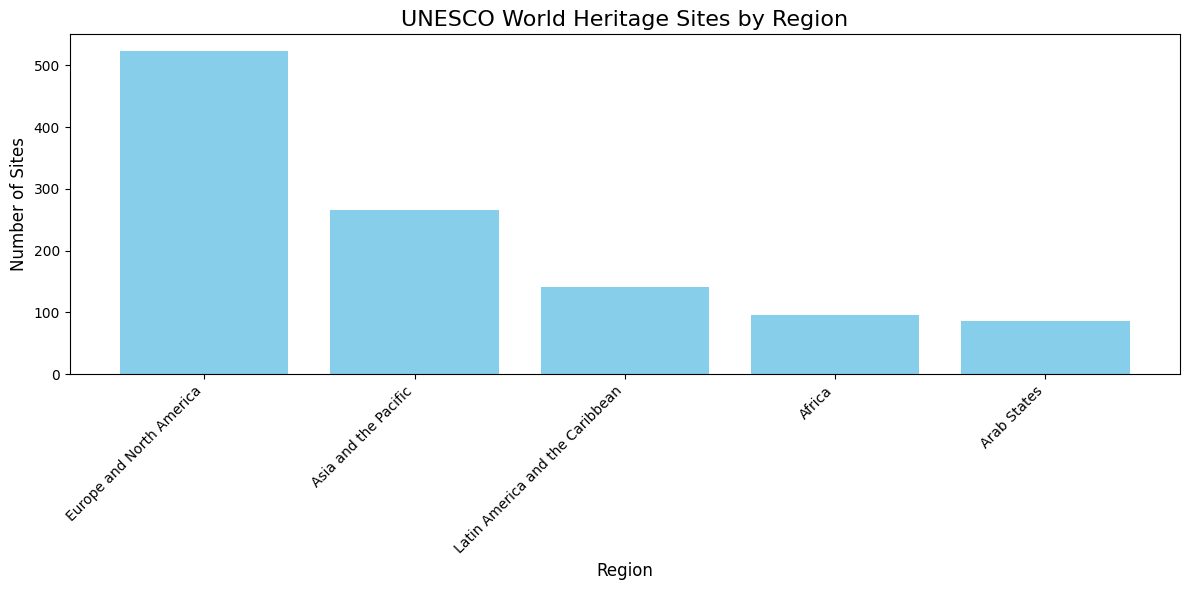


UNESCO Sites Distribution by Region:
Europe and North America      :  524 sites
Asia and the Pacific          :  266 sites
Latin America and the Caribbean:  141 sites
Africa                        :   96 sites
Arab States                   :   86 sites


In [21]:
if conn:
    # Create a heatmap of UNESCO sites by region
    try:
        cursor.execute("""
        SELECT REGION_EN, COUNT(*) as site_count
        FROM UNESCO_SITES_COPY
        GROUP BY REGION_EN
        ORDER BY site_count DESC
        """)

        rows = cursor.fetchall()

        # Create bar chart
        import matplotlib.pyplot as plt

        regions = [row[0] for row in rows]
        counts = [row[1] for row in rows]

        plt.figure(figsize=(12, 6))
        plt.bar(regions, counts, color='skyblue')
        plt.title('UNESCO World Heritage Sites by Region', fontsize=16)
        plt.xlabel('Region', fontsize=12)
        plt.ylabel('Number of Sites', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        print("\nUNESCO Sites Distribution by Region:")
        for region, count in zip(regions, counts):
            print(f"{region:30}: {count:4} sites")

    except Exception as e:
        print(f"✗ Error creating visualization: {e}")

## Section 11: Advanced Geographic Queries

Demonstrate more complex geographic queries with SelectAI.

In [22]:
if conn:
    print("\n" + "="*80)
    print("ADVANCED GEOGRAPHIC QUERIES")
    print("="*80)

    # Advanced Query 1: Sites near specific coordinates
    prompt6 = 'Find UNESCO sites within 10 degrees latitude of the equator'

    try:
        cursor.execute(f"""
        SELECT DBMS_CLOUD_AI.GENERATE(
            prompt       => '{prompt6}',
            profile_name => 'COHERE_UNESCO',
            action       => 'showsql'
        ) as generated_query
        FROM dual
        """)

        result = cursor.fetchone()
        generated_sql_6 = result[0]

        print(f"\nAdvanced Query 1: {prompt6}")
        print("=" * 70)
        print("Generated SQL:")
        print(generated_sql_6)
        print()

        # Execute the query and show results
        cursor.execute(str(generated_sql_6))
        rows = cursor.fetchall()
        col_names = [description[0] for description in cursor.description]

        df = pd.DataFrame(rows, columns=col_names)
        print(f"Results: {len(df)} sites found near equator")
        print(df.head())

    except Exception as e:
        print(f"✗ Error in Advanced Query 1: {e}")

    # Advanced Query 2: Regional comparison
    prompt7 = 'Compare the number of cultural vs natural sites in each region'

    try:
        cursor.execute(f"""
        SELECT DBMS_CLOUD_AI.GENERATE(
            prompt       => '{prompt7}',
            profile_name => 'COHERE_UNESCO',
            action       => 'showsql'
        ) as generated_query
        FROM dual
        """)

        result = cursor.fetchone()
        generated_sql_7 = result[0]

        print(f"\nAdvanced Query 2: {prompt7}")
        print("=" * 70)
        print("Generated SQL:")
        print(generated_sql_7)
        print()

        # Execute the query and show results
        cursor.execute(str(generated_sql_7))
        rows = cursor.fetchall()
        col_names = [description[0] for description in cursor.description]

        df = pd.DataFrame(rows, columns=col_names)
        print(f"Results: Regional comparison completed")
        print(df.head())

    except Exception as e:
        print(f"✗ Error in Advanced Query 2: {e}")


ADVANCED GEOGRAPHIC QUERIES

Advanced Query 1: Find UNESCO sites within 10 degrees latitude of the equator
Generated SQL:
SELECT "ID", "NAME_EN", "REGION_EN", "STATES_NAME_EN", "CATEGORY", "LONGITUDE", "LATITUDE"
FROM "DEMOUSER"."UNESCO_SITES_COPY" us
WHERE ABS("LATITUDE") <= 10

Results: 101 sites found near equator
    ID                                            NAME_EN  \
0   36  Mbanza Kongo, Vestiges of the Capital of the f...   
1   61                            Royal Palaces of Abomey   
2   89                Central Amazon Conservation Complex   
3   91  Brazilian Atlantic Islands: Fernando de Noronh...   
4  220                          Los KatÃ­os National Park   

                         REGION_EN STATES_NAME_EN  CATEGORY  LONGITUDE  \
0                           Africa         Angola  Cultural  14.249722   
1                           Africa          Benin  Cultural   1.983333   
2  Latin America and the Caribbean         Brazil   Natural -62.008333   
3  Latin America 

## Section 12: Handle Connection Errors and Cleanup

Properly close database connections and handle any errors.

In [23]:
# Close database connection
if conn:
    try:
        conn.close()
        print("✓ Database connection closed")
    except Exception as e:
        print(f"✗ Error closing connection: {e}")

✓ Database connection closed


## Troubleshooting Guide

### Connection Issues
- **Wallet not found**: Ensure wallet.zip is uploaded to Google Drive at the correct path
- **TNS name error**: Verify the TNS name matches your Oracle Cloud Console wallet
- **Authentication failed**: Check username and password are correct

### SelectAI Issues
- **Cohere API errors**: Verify API key is valid and not expired
- **Permission denied**: Ensure ADMIN user granted DBMS_CLOUD_AI privileges
- **Profile not found**: Check that profile was created successfully

### API Key Security
- Never commit real Cohere API keys to repositories
- Use environment variables or Google Colab secrets for sensitive data
- Rotate keys periodically for security

### Geographic Query Tips
- Use specific region names (e.g., 'Europe and North America')
- Include coordinate ranges for precise location queries
- Combine multiple criteria for complex geographic analysis

## Next Steps

1. Customize the natural language prompts for your specific UNESCO data analysis needs
2. Create additional AI profiles for different geographic analysis scenarios
3. Integrate results with pandas for advanced data analysis
4. Build interactive dashboards with Streamlit or other visualization tools
5. Explore spatial functions for distance and proximity calculations

## References

- [Oracle SelectAI Documentation](https://docs.oracle.com/en/cloud/paas/autonomous-database/index.html)
- [Cohere API Documentation](https://docs.cohere.ai/)
- [oracledb Python Driver](https://python-oracledb.readthedocs.io/)
- [UNESCO World Heritage Centre](https://whc.unesco.org/)
- [Folium Documentation](https://python-visualization.github.io/folium/)